In [3]:
import numpy as np
import sympy as sp

%matplotlib nbagg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pyJHTDB
from pyJHTDB import libJHTDB
from pyJHTDB.dbinfo import interpolation_code
from pyJHTDB.dbinfo import channel as info

import pickle

/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
nu = 5e-5
Prandtl = 1/10.
kappa = nu/Prandtl
kolmogorov_time = 1e-3
kolmogorov_length = 1


Lx = info['lx']
Ly = info['ly']
Lz = info['lz']

Top = Ly/2
Bottom = -Ly/2
eps = Ly/100

npoints = 2
nparticles = 100
nsteps = info['time'].shape[0]

T = info['time'][-1];
subdivisions = 2
t = np.linspace(info['time'][-1], info['time'][0], num = subdivisions*nsteps+1)
tau = t[0]-t
dt              = t[0] - t[1]
sqrtdt          = abs(dt)**.5
noiseamplitude  = (2*kappa)**.5

x0         = np.zeros(shape = (npoints, nparticles, 3), dtype = np.float32)
x0[..., 0] = Lx*np.random.random(size = (npoints,))[:, None]
x0[..., 1] = info['ynodes'][info['ynodes'].shape[0]//5]
x0[..., 2] = Lz*np.random.random(size = (npoints,))[:, None]
x          = x0.copy()
LB         = np.empty(shape = (npoints, nparticles, 3), dtype = np.float32)
LT         = np.empty(shape = (npoints, nparticles, 3), dtype = np.float32)
HT         = (info['time'][-1]+1)**2*np.ones(shape = (npoints, nparticles, 1), dtype = np.float32)
r          = np.empty(shape = (npoints, nparticles,  nparticles), dtype = np.float32)
disp       = np.empty(shape = (subdivisions*nsteps, npoints), dtype = np.float32)
numcombs   = nparticles*(nparticles-1)/2

In [ ]:
lJHTDB = libJHTDB()
lJHTDB.initialize()

for tindex in range(subdivisions*nsteps):
    print('step {0} of {1}'.format(tindex,subdivisions*nsteps))
    u = lJHTDB.getData(
                t[tindex],
                x,
                sinterp = interpolation_code['M2Q8'],
                tinterp = interpolation_code['NoTInt'],
                data_set = info['name'],
                getFunction = 'getVelocity')
    dW = np.random.randn(*x.shape)*sqrtdt
    dX = -u*dt + noiseamplitude*dW
    x += dX
    for k in range(npoints):
        for i in range(nparticles):
            for j in range(nparticles):
                if i<j:
                    r[k,i,j] =  np.sum(np.square(x[k, i, :] - x[k, j, :]))           
    disp[tindex] = np.sum(np.sum(r, axis=2),axis=1)/numcombs
    
    cond1 = x[..., 1] < Bottom + eps
    cond2 = x[..., 1] > Top    - eps
    HT[np.logical_or(cond1, cond2)] = np.minimum(HT[np.logical_or(cond1, cond2)], tau[tindex])
    c1indices = np.where(cond1)   
    if c1indices[0].size > 0:
        V  =  -2*dt*np.log(np.random.random(x.shape))[c1indices]
        Y  = (-dX[c1indices] + np.sqrt(2*kappa*V + dX[c1indices]**2))/2
        dL =  Y - x[c1indices] + Bottom
        dL[np.where(dL < 0)] = 0
        x[c1indices]  += dL
        LB[c1indices] += dL/kappa
    c2indices = np.where(cond2) 
    if c2indices[0].size > 0:
        V  =  -2*dt*np.log(np.random.random(x.shape))[c2indices]
        Y  = (-dX[c2indices] + np.sqrt(2*kappa*V + dX[c2indices]**2))/2
        dL =  Y + x[c2indices] - Top
        dL[np.where(dL < 0)] = 0
        x[c2indices]  -= dL
        LT[c2indices] += dL/kappa
    x[..., 1] = np.clip(x[..., 1], Bottom, Top)
lJHTDB.finalize() 

step 0 of 2048
step 1 of 2048
step 2 of 2048
step 3 of 2048
step 4 of 2048
step 5 of 2048
step 6 of 2048
step 7 of 2048
step 8 of 2048
step 9 of 2048
step 10 of 2048
step 11 of 2048
step 12 of 2048
step 13 of 2048
step 14 of 2048
step 15 of 2048
step 16 of 2048
step 17 of 2048
step 18 of 2048
step 19 of 2048
step 20 of 2048
step 21 of 2048
step 22 of 2048
step 23 of 2048
step 24 of 2048
step 25 of 2048
step 26 of 2048
step 27 of 2048
step 28 of 2048
step 29 of 2048
step 30 of 2048
step 31 of 2048
step 32 of 2048
step 33 of 2048
step 34 of 2048
step 35 of 2048
step 36 of 2048
step 37 of 2048
step 38 of 2048
step 39 of 2048
step 40 of 2048
step 41 of 2048
step 42 of 2048
step 43 of 2048
step 44 of 2048
step 45 of 2048
step 46 of 2048
step 47 of 2048
step 48 of 2048
step 49 of 2048
step 50 of 2048
step 51 of 2048
step 52 of 2048
step 53 of 2048
step 54 of 2048
step 55 of 2048
step 56 of 2048
step 57 of 2048
step 58 of 2048
step 59 of 2048
step 60 of 2048
step 61 of 2048
step 62 of 2048
st

In [10]:
####### Dump Data #######

#suffix = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl)
#pickle.dump(x, open( "data_channel/x"          + suffix, "wb" ) )
#pickle.dump(t, open( "data_channel/t"           + suffix, "wb" ) )
#pickle.dump(LT, open( "data_channel/LT"         + suffix, "wb" ) )
#pickle.dump(LB, open( "data_channel/LB"         + suffix, "wb" ) )
#pickle.dump(HT, open( "data_channel/HT"         + suffix, "wb" ) )
#pickle.dump(disp, open( "data_channel/disp"     + suffix, "wb" ) )

####### Load Data #######
nparticles = 100
Prandtl1 = 1
#Prandtl2 = 1/10.
suffix1 = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl1)
#suffix2 = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandt2)
t = pickle.load( open( "data_channel/t"    + suffix1, "rb" ) )
LT = pickle.load( open( "data_channel/LT"  + suffix1, "rb" ) )
LB = pickle.load( open( "data_channel/LB"  + suffix1, "rb" ) )
HT = pickle.load( open( "data_channel/HT"  + suffix1, "rb" ) )
disp1 = pickle.load( open( "data_channel/disp"  + suffix1, "rb" ) )
#LT2 = pickle.load( open( "data_channel/LT"  + suffix2, "rb" ) )
#LB2 = pickle.load( open( "data_channel/LB"  + suffix2, "rb" ) )
#HT2 = pickle.load( open( "data_channel/HT"  + suffix2, "rb" ) )
#disp2 = pickle.load( open( "data_channel/disp"  + suffix2, "rb" ) )

<IPython.core.display.Javascript object>


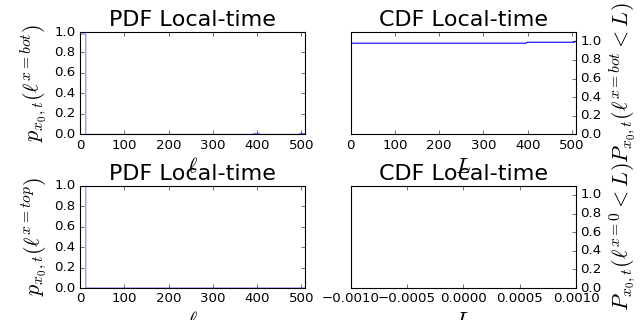

/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0.0
  'left=%s, right=%s') % (left, right))


In [6]:
space_index   =  0
dataB         = LB[space_index,:,1]
dataT         = LT[space_index,:,1]
MB            = np.max(dataB)
MT            = np.max(dataT)

fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fig.subplots_adjust(hspace=.5)

####################################
######## BOTTOM LOCAL TIME #########
####################################

bins = np.linspace(0, MB, 40)
N = nparticles
weights = np.ones_like(dataB[:])/N
ax1.hist(dataB, weights = weights, bins = bins, alpha=0.5, histtype = 'step')
#ax1.hist(dataB, normed = 1, bins = bins, alpha=0.5, histtype = 'step')

ax1.set_title('PDF Local-time', fontsize=20)
ax1.set_xlim([0,MB])
ax1.set_xlabel('$\ell$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\ell^{x=bot})$', fontsize=20)

values, base = np.histogram(dataB, bins = 300, normed = 0)
cumulative   = np.cumsum(values)/float(dataB.shape[0])
ax2.plot(base[:-1], cumulative, c='blue')


ax2.set_xlim([0,MB])
ax2.set_ylim([0,1.1])
ax2.set_title('CDF Local-time', fontsize=20)
ax2.set_xlabel('$L$', fontsize=20)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('$P_{x_0,t}(\\ell^{x=bot}<L)$', fontsize=20)




bins = np.linspace(0, MB, 40)
N = nparticles
weights = np.ones_like(dataT[:])/N
ax3.hist(dataT, weights = weights, bins = bins, alpha=0.5, histtype = 'step')

ax3.set_title('PDF Local-time', fontsize=20)
ax3.set_xlim([0,MB])
ax3.set_xlabel('$\ell$', fontsize=20)
ax3.set_ylabel('$p_{x_0,t}(\\ell^{x=top})$', fontsize=20)

values, base = np.histogram(dataT, bins = 300, normed = 0)
cumulative   = np.cumsum(values)/float(dataT.shape[0])
ax2.plot(base[:-1], cumulative, c='blue')


ax4.set_xlim([0,MT])
ax4.set_ylim([0,1.1])
ax4.set_title('CDF Local-time', fontsize=20)
ax4.set_xlabel('$L$', fontsize=20)
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.set_ylabel('$P_{x_0,t}(\\ell^{x=0}<L)$', fontsize=20)

<IPython.core.display.Javascript object>


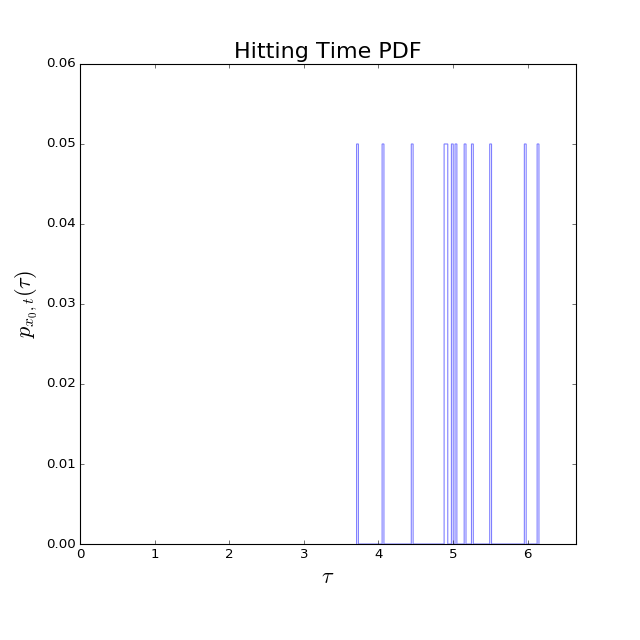

In [7]:
space_index1 = 0
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
fig.subplots_adjust(hspace=.5)

plt.gcf().subplots_adjust(bottom=0.15)

data1 = HT[space_index1, :, np.newaxis]
data1 = data1[data1 < (T+1)**2]
MD1 = np.max(data1)

N = nparticles/5
weights1 = np.ones_like(data1[:])/N

ax1.hist(data1, weights = weights1, bins = 100, alpha=0.5,  histtype = 'step')
taus = np.linspace(0.001, T, 350)
ax1.set_title('Hitting Time PDF', fontsize=20)
ax1.set_xlim([0,T])
ax1.set_xlabel('$\\tau$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\tau)$', fontsize=20)

<IPython.core.display.Javascript object>


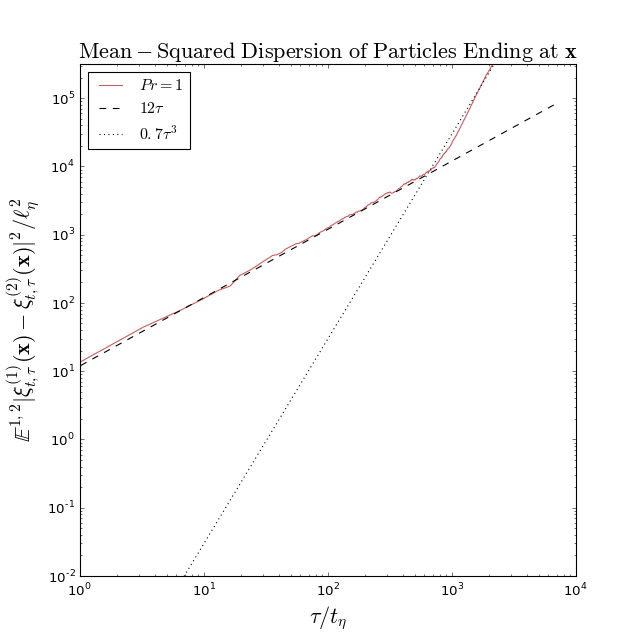

In [48]:
kolmogorov_time = 1e-3
Tau = tau/kolmogorov_time
diffusion_dispersion1 = 12*Tau/Prandtl1
#diffusion_dispersion2 = 12*TTau/Prandtl2
Richardson_dispersion = 3e-5*Tau**3

space_point_index = 1
dispersion1 = disp1[:,space_point_index]/(0.05*kolmogorov_time**2)
disper1 = [0]
disper1.extend(dispersion1)

#dispersion2 = disp2[:,space_point_index]/(kolmogorov_length**2)
#disper2 = [0]
#disper2.extend(dispersion2)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(Tau, disper1, color = 'Indianred', label = '$Pr = {0}$'.format(Prandtl1))
#ax.plot(Tau, disper2, color = 'Steelblue', label = '$Pr = {0}$'.format(Prandtl2))
ax.plot(Tau, diffusion_dispersion1,   color = 'black', linestyle = 'dashed', label = '$12 \\tau$')
#ax.plot(Tau, diffusion_dispersion2,   color = 'black', linestyle = 'dashdot', label = '$120 \\tau$')
ax.plot(Tau, Richardson_dispersion,  color = 'black', linestyle = 'dotted', label = '$0.7 \\tau^3$')
ax.set_ylim([10**(-2),10**(5.5)])
ax.set_title('$\\rm Mean-Squared\ Dispersion\ of\ Particles\ Ending\ at\ \\mathbf{x}$', fontsize=20)
ax.set_xlabel('$\\tau / t_\\eta$', fontsize=20)
ax.set_ylabel('$\mathbb{E}^{1,2} |{\\xi}^{(1)}_{t,\\tau}(\\mathbf{x})-{\\xi}^{(2)}_{t,\\tau}(\\mathbf{x})|^2 /\\ell_\\eta^2$', fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc ="best")

# 